# Backtesting

## What is the "挖因子" in quantitative trading?

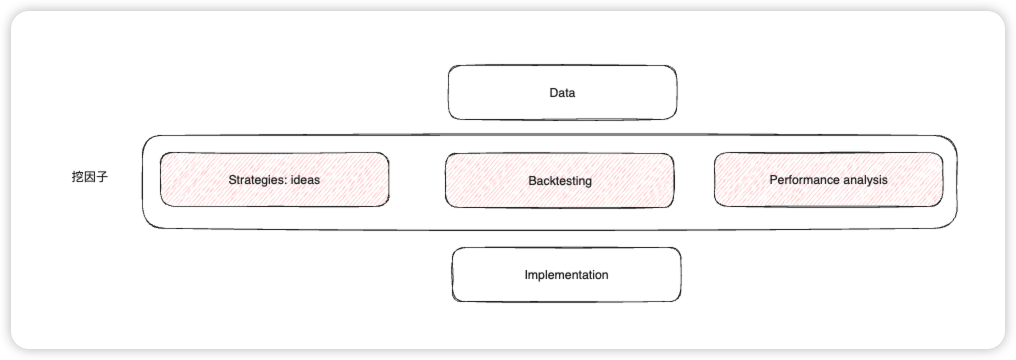

## Data

In [1]:
import ccxt
import pandas as pd
import talib

In [2]:
exchange = ccxt.okx({})
# exchange.set_sandbox_mode(True)
exchange.load_markets()
exchange.verbose = False

In [3]:
ohlcv = exchange.fetch_ohlcv('BTC/USDT', '1d')
ori_df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
ori_df['timestamp'] = pd.to_datetime(ori_df['timestamp'], unit='ms')

In [4]:
ori_df

,timestamp,open,high,low,close,volume
0,2024-02-22,51848.1,52080.0,50936.0,51290.0,10195.356881
1,2024-02-23,51290.1,51547.3,50513.1,50748.2,10224.104293
2,2024-02-24,50749.9,51700.0,50574.0,51563.6,5026.950298
3,2024-02-25,51567.4,51984.8,51266.4,51731.4,5316.715776
4,2024-02-26,51731.4,54923.0,50902.2,54471.0,15063.988074
...,...,...,...,...,...,...
95,2024-05-27,68506.3,70688.0,68256.3,69416.1,5825.167439
96,2024-05-28,69416.1,69614.4,67264.3,68405.9,7842.235510
97,2024-05-29,68406.0,68934.6,67137.5,67647.7,5756.618376
98,2024-05-30,67647.6,69515.0,67123.9,68357.9,8033.249552


## Strategy idea

### EMA strategy

In [84]:
"""
fast line = EMA(9)
slow line = EMA(21)

When fast line crosses above slow line, buy
When fast line crosses below slow line, sell
"""

'\nfast line = EMA(9)\nslow line = EMA(21)\n\nWhen fast line crosses above slow line, buy\nWhen fast line crosses below slow line, sell\n'

In [5]:
ori_df['return'] = ori_df['close'].pct_change()

In [6]:
ori_df['EMA_fast'] = ori_df['close'].ewm(span=9, adjust=False).mean()
ori_df['EMA_slow'] = ori_df['close'].ewm(span=21, adjust=False).mean()

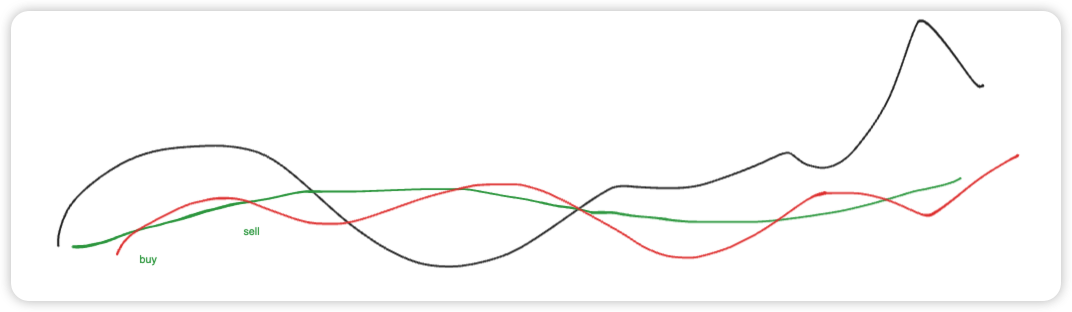

## Backtesting

### Method 1: Vetorization backtesting (long-short)


In [7]:
df = ori_df.copy()

In [8]:
df['position'] = 0  # Initialize signal column with 0
# Set signal as 1 (buy signal) when EMA_fast is greater than EMA_slow
df.loc[df['EMA_fast'] > df['EMA_slow'], 'position'] = 1
# Set signal as -1 (sell signal) when EMA_fast is less than or equal to EMA_slow
df.loc[df['EMA_fast'] < df['EMA_slow'], 'position'] = -1
df

,timestamp,open,high,low,close,volume,return,EMA_fast,EMA_slow,position
0,2024-02-22,51848.1,52080.0,50936.0,51290.0,10195.356881,NaN,51290.000000,51290.000000,0
1,2024-02-23,51290.1,51547.3,50513.1,50748.2,10224.104293,-0.010563,51181.640000,51240.745455,-1
2,2024-02-24,50749.9,51700.0,50574.0,51563.6,5026.950298,0.016068,51258.032000,51270.095868,-1
3,2024-02-25,51567.4,51984.8,51266.4,51731.4,5316.715776,0.003254,51352.705600,51312.032607,1
4,2024-02-26,51731.4,54923.0,50902.2,54471.0,15063.988074,0.052958,51976.364480,51599.211461,1
...,...,...,...,...,...,...,...,...,...,...
95,2024-05-27,68506.3,70688.0,68256.3,69416.1,5825.167439,0.013281,68404.433287,66791.091812,1
96,2024-05-28,69416.1,69614.4,67264.3,68405.9,7842.235510,-0.014553,68404.726629,66937.892557,1
97,2024-05-29,68406.0,68934.6,67137.5,67647.7,5756.618376,-0.011084,68253.321304,67002.420506,1
98,2024-05-30,67647.6,69515.0,67123.9,68357.9,8033.249552,0.010499,68274.237043,67125.645915,1


In [11]:
df['last_3 days return'] = df['return'].rolling(3).sum()
df['last_5 days return'] = df['return'].rolling(5).sum()
df['last_2 days EMA'] = df['close'].ewm(span=2, adjust=False).mean()



In [12]:
df.iloc[0:4]

,timestamp,open,high,low,close,volume,return,EMA_fast,EMA_slow,position,last_3 days return,last_5 days return,last_2 days EMA
0,2024-02-22,51848.1,52080.0,50936.0,51290.0,10195.356881,NaN,51290.0000,51290.000000,0,NaN,NaN,51290.000000
1,2024-02-23,51290.1,51547.3,50513.1,50748.2,10224.104293,-0.010563,51181.6400,51240.745455,-1,NaN,NaN,50928.800000
2,2024-02-24,50749.9,51700.0,50574.0,51563.6,5026.950298,0.016068,51258.0320,51270.095868,-1,NaN,NaN,51352.000000
3,2024-02-25,51567.4,51984.8,51266.4,51731.4,5316.715776,0.003254,51352.7056,51312.032607,1,0.008758,NaN,51604.933333


In [13]:
df['roi'] = df['return'] * df['position'].shift()
return_df = df['roi'].fillna(0).cumsum()

<Axes: >

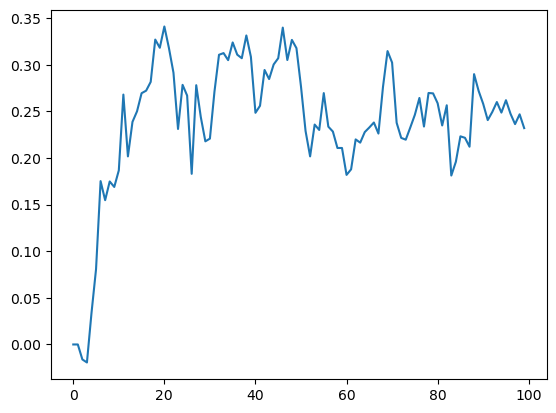

In [14]:
return_df.plot()

### Method 2: Event-driven backtesting

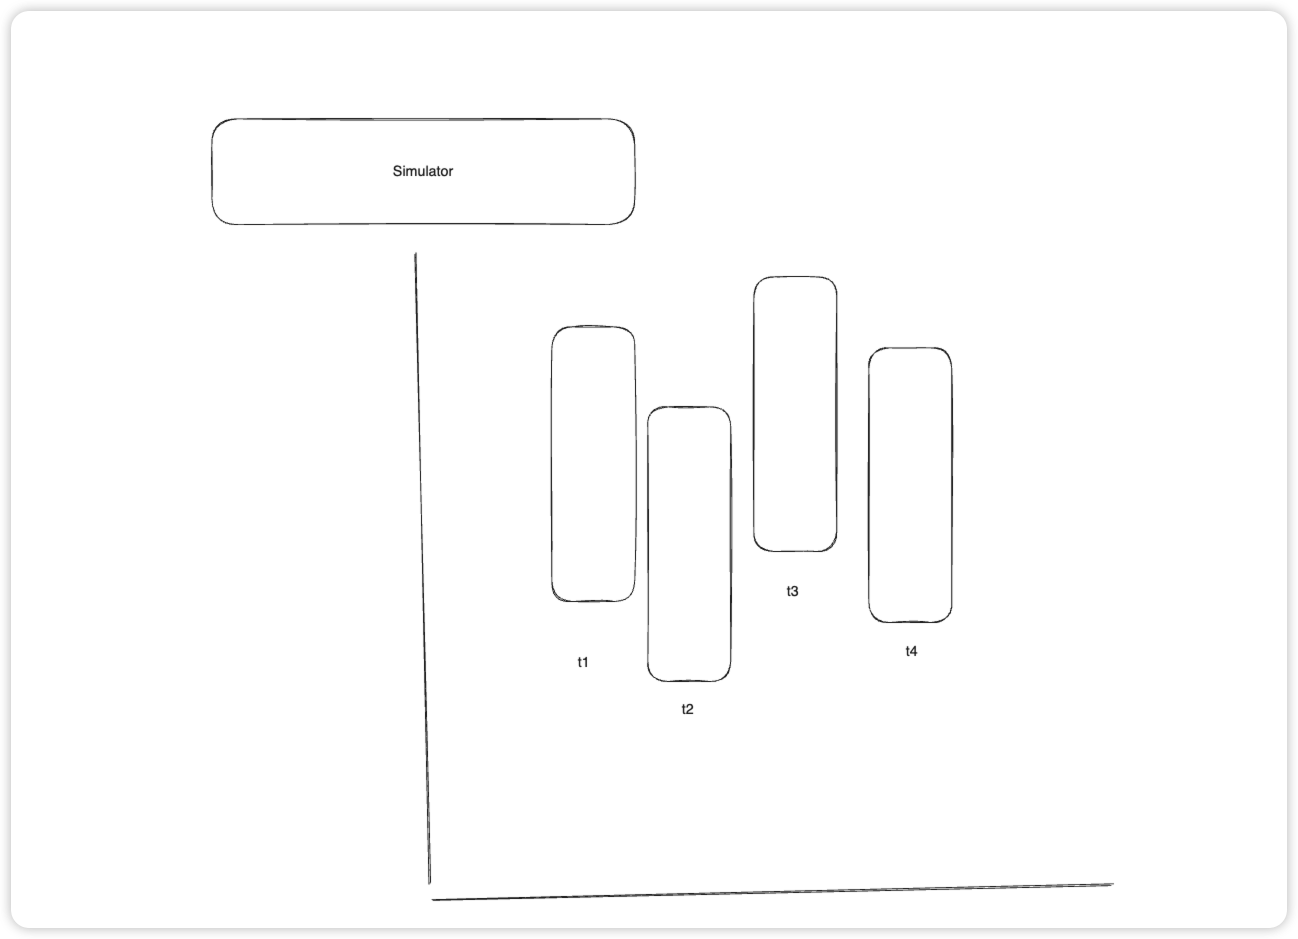

In [95]:
! pip3 install backtesting

  Using cached Backtesting-0.3.3-py3-none-any.whl


In [15]:
from backtesting import Strategy
from backtesting.lib import crossover

In [16]:
def EMA(values, n):
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).ewm(span=n, min_periods=n).mean()

In [18]:
from backtesting import Strategy
from backtesting.lib import crossover


class EMAStrategy(Strategy):
    # Define the two MA lags as *class variables*
    # for later optimization
    n1 = 2
    n2 = 9
    
    def init(self):
        # Precompute the two moving averages
        self.ema1 = self.I(EMA, self.data.Close, self.n1)
        self.ema2 = self.I(EMA, self.data.Close, self.n2)
    
    def next(self):
            
        if crossover(self.ema1, self.ema2):
            self.position.close()
            self.buy()

        elif crossover(self.ema2, self.ema1):
            self.position.close()
            self.sell()

In [19]:
data = ori_df.copy().set_index('timestamp')

In [20]:
data.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)

In [21]:
from backtesting import Backtest

bt = Backtest(data, EMAStrategy, cash=10000000, commission=.002)
stats = bt.run()
stats

Start                     2024-02-22 00:00:00
End                       2024-05-31 00:00:00
Duration                     99 days 00:00:00
Exposure Time [%]                        76.0
Equity Final [$]                 7141762.8432
Equity Peak [$]                 10495901.0908
Return [%]                         -28.582372
Buy & Hold Return [%]               31.303763
Return (Ann.) [%]                  -70.732219
Volatility (Ann.) [%]               15.925727
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -33.529618
Avg. Drawdown [%]                  -19.229269
Max. Drawdown Duration       73 days 00:00:00
Avg. Drawdown Duration       38 days 00:00:00
# Trades                                   15
Win Rate [%]                             20.0
Best Trade [%]                       3.058019
Worst Trade [%]                     -7.750622
Avg. Trade [%]                    

In [22]:
bt.plot()

Row(id='1433', ...)

|                               | Evendriven backtesting                                                   | Vectorization                                        |
| ----------------------------- | ------------------------------------------------------------ | ---------------------------------------------------- |
| Speed                         | slow                                                      | fast                    |
| Parallelism,  multiple stocks | Built-in and optimized                                       | Depending on the pandas                              |
| Learning Curve                | High                                                         | Low                                                  |
| Suitable                      | Can handle complex scenarios, including non-vectorizable operation or dynamic decision-making at each step. | Suitable for vectorizable operations                 |
| Implementation Efficiency     | Slower                                                       | Quick                                                |
| Realism                       | more realism                                                 | sacrifice some realism                               |
| Coding lines                  | 162 lines                                                    | 28 lines                                             |
| Readable                      | Higher (Needs to learn it firstly)                           | Lower (different people have different coding style) |
| Extendable or maintainable    | Better(it is module-based)                                   | Lower(needs to run again and again)                  |
|                               |                                                              |                                                      |


## Portfolio analysis `quantstats`

In [23]:
import quantstats as qs

# extend pandas functionality with metrics, etc.
qs.extend_pandas()

# fetch the daily returns for a stock
stock = qs.utils.download_returns('META')

# show sharpe ratio
qs.stats.sharpe(stock)

# or using extend_pandas() :)
stock.sharpe()

[*********************100%%**********************]  1 of 1 completed


0.7149950696889497